In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [3]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.preprocessing.text import Tokenizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
import autokeras as ak
from collections import Counter
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')

Using TensorFlow backend
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [6]:
df1 = df.copy()

In [7]:
df1.iloc[4][1]

"mother comes pretty close to using word 'streaming' correctly"

In [8]:
df1.iloc[6][1]

'5 ways to file your taxes with less stress'

In [9]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [11]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [12]:
df.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

# Cleaning the data

In [13]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)

In [14]:
stop.update(punctuation)

In [15]:
def text_cleaner(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\']',' ',text)
    text = text.split()
    text = [word for word in text if word not in stop]
    text = ' '.join(text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub(r'   ', ' ', text)
    return text

In [16]:
df['headline'] = df['headline'].apply(text_cleaner)

/tmp/ipykernel_43/358267025.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [17]:
df.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep totally nails congress falling short g...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat veggies deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close using word 'streamin...,https://www.theonion.com/mother-comes-pretty-c...


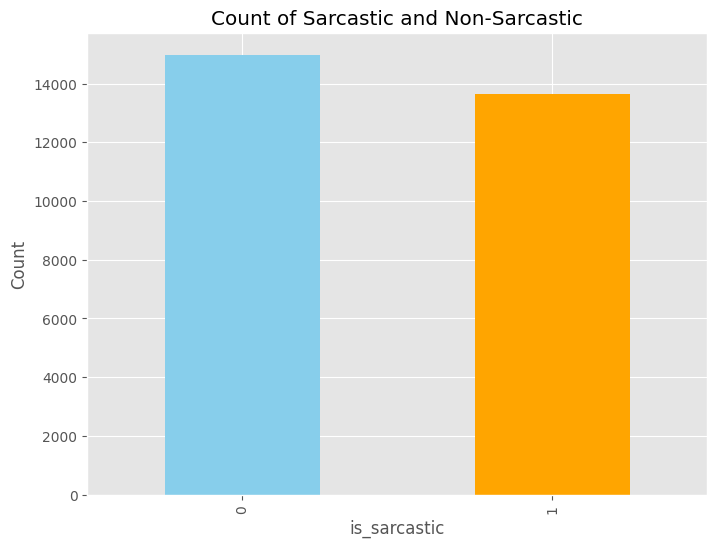

In [60]:
plt.figure(figsize=(8, 6))
df['is_sarcastic'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Count of Sarcastic and Non-Sarcastic')
plt.xlabel('is_sarcastic')
plt.ylabel('Count')
plt.show()

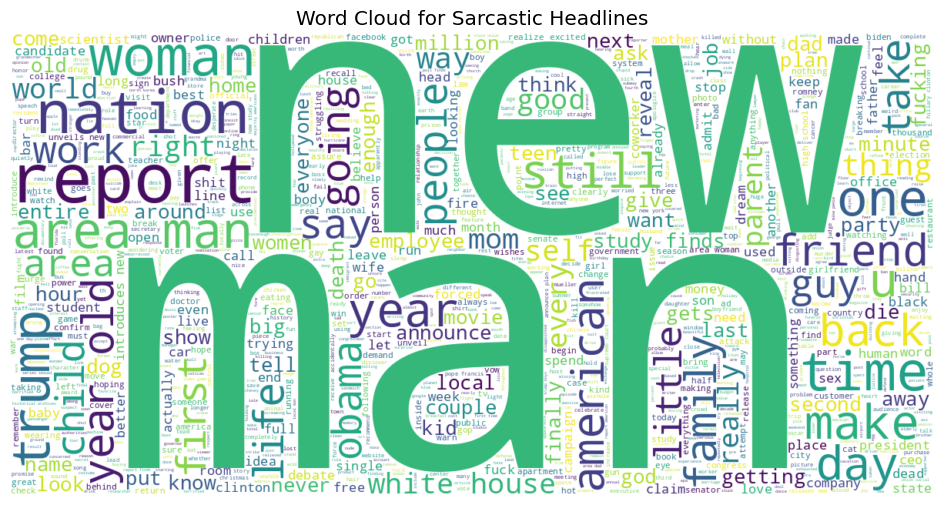

In [61]:
sarcastic_text = " ".join(df[df.is_sarcastic == 1].headline)

wc = WordCloud(max_words=2000, width=1200, height=600, background_color='white').generate(sarcastic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Sarcastic Headlines')
plt.show()

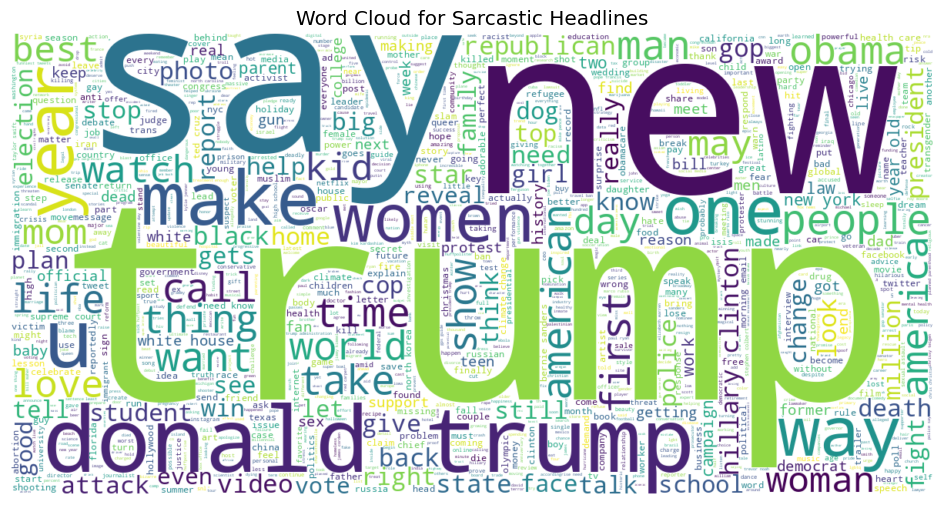

In [62]:
sarcastic_text = " ".join(df[df.is_sarcastic == 0].headline)

wc = WordCloud(max_words=2000, width=1200, height=600, background_color='white').generate(sarcastic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Sarcastic Headlines')
plt.show()

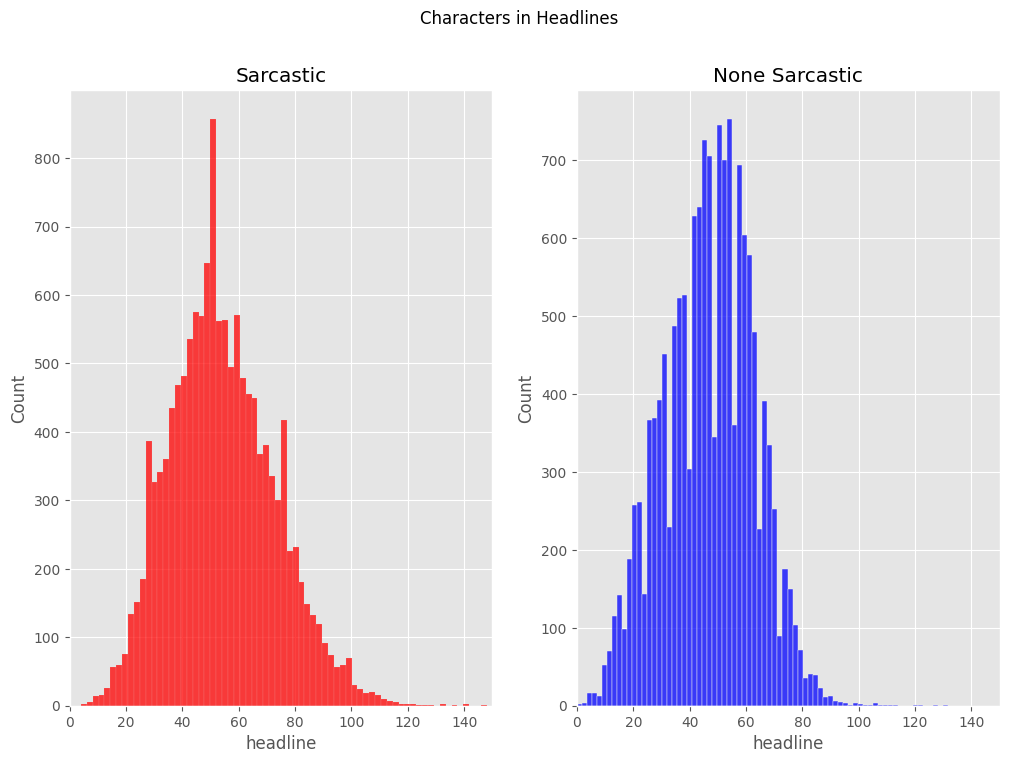

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.histplot(df[df['is_sarcastic'] == 1]['headline'].str.len(), color='red', ax=ax1)
ax1.set_title('Sarcastic')
ax1.set_xlim(0, 150)

sns.histplot(df[df['is_sarcastic'] == 0]['headline'].str.len(), color='blue', ax=ax2)
ax2.set_title('None Sarcastic')
ax2.set_xlim(0, 150)

fig.suptitle('Characters in Headlines')
plt.show()

In [64]:
def convert_to_list(text):
    return [word.strip() for sentence in text for word in sentence.split()]

In [65]:
words_list = convert_to_list(df.headline)

In [66]:
def count_words(words):
    word_counts = Counter(words)
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_counts

In [67]:
common_words = count_words(words_list)
common_words[:10]

[('new', 1658),
 ('trump', 1412),
 ('man', 1379),
 ('report', 605),
 ('one', 566),
 ('year', 541),
 ('u', 509),
 ('day', 507),
 ('area', 500),
 ('woman', 493)]

In [68]:
len(common_words)

30154

* We have around 30k unique words.
* Some of them are not practical.

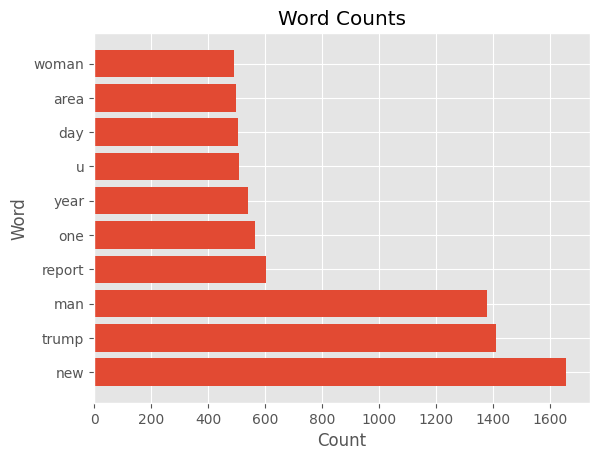

In [69]:
words, counts = zip(*common_words[:10])
plt.style.use('ggplot')

plt.barh(words, counts)
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Word Counts')
plt.show()

# Training the data 

# LSTM - Model 1

In [26]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic,random_state = 0)

In [27]:
max_features = 10000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [32]:
batch_size = 256
epochs = 10
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [34]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [36]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
84/84 [==============================] - 170s 2s/step - loss: 0.6790 - accuracy: 0.5697 - val_loss: 0.6872 - val_accuracy: 0.5604 - lr: 0.0010
Epoch 2/10
84/84 [==============================] - 162s 2s/step - loss: 0.6634 - accuracy: 0.5982 - val_loss: 0.6547 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 3/10
84/84 [==============================] - 163s 2s/step - loss: 0.6546 - accuracy: 0.6100 - val_loss: 0.6557 - val_accuracy: 0.6092 - lr: 0.0010
Epoch 4/10
84/84 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.6140
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
84/84 [==============================] - 164s 2s/step - loss: 0.6522 - accuracy: 0.6140 - val_loss: 0.6586 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 5/10
84/84 [==============================] - 164s 2s/step - loss: 0.6487 - accuracy: 0.6186 - val_loss: 0.6502 - val_accuracy: 0.6148 - lr: 5.0000e-04
Epoch 6/10
84/84 [==============================] - 163s 2s/step - 

In [37]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

671/671 [==============================] - 59s 88ms/step - loss: 0.6349 - accuracy: 0.6323
Accuracy of the model on Training Data is -  63.23145627975464 %
224/224 [==============================] - 19s 83ms/step - loss: 0.6469 - accuracy: 0.6235
Accuracy of the model on Testing Data is -  62.348008155822754 %


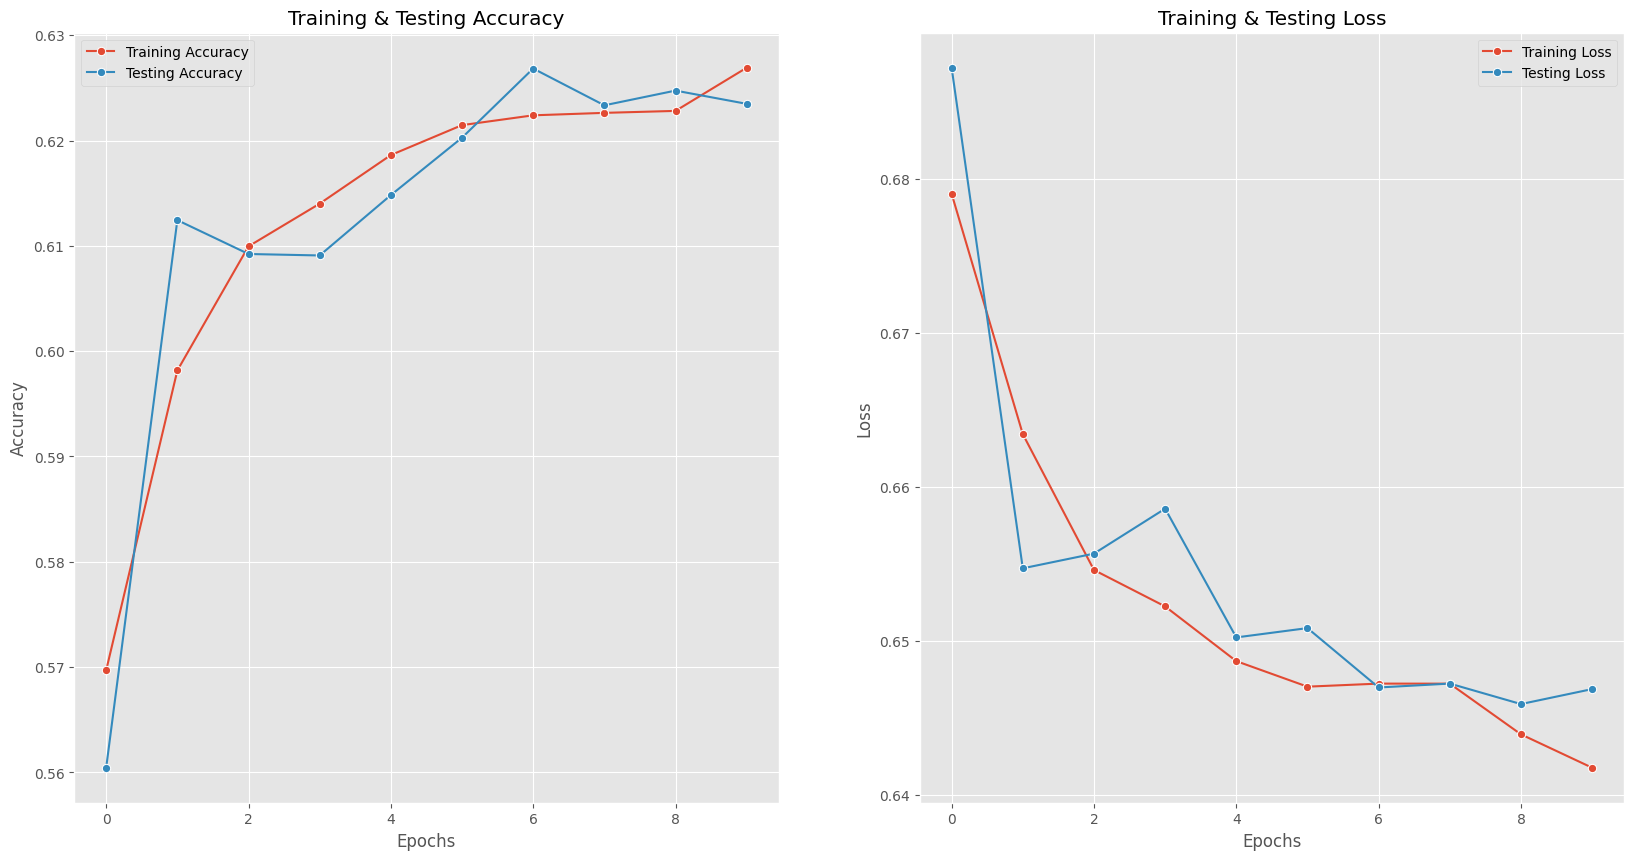

In [38]:
epochs = [i for i in range(10)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(x=epochs, y=train_acc, ax=axes[0], marker='o', label='Training Accuracy')
sns.lineplot(x=epochs, y=val_acc, ax=axes[0], marker='o', label='Testing Accuracy')
axes[0].set_title('Training & Testing Accuracy')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

sns.lineplot(x=epochs, y=train_loss, ax=axes[1], marker='o', label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, ax=axes[1], marker='o', label='Testing Loss')
axes[1].set_title('Training & Testing Loss')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()


# Naive Bayes

In [70]:
X = np.array(df['headline'])
y = np.array(df['is_sarcastic'])

cv = CountVectorizer()
X = cv.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [71]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

In [72]:
pred_bnb = bnb.predict(X_test)

In [73]:
print(f'Bernoulli Accuracy: {accuracy_score(y_test, pred_bnb)}')
print('\n')
print(classification_report(y_test, pred_bnb))

Bernoulli Accuracy: 0.8212788259958071


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3030
           1       0.84      0.77      0.80      2694

    accuracy                           0.82      5724
   macro avg       0.82      0.82      0.82      5724
weighted avg       0.82      0.82      0.82      5724



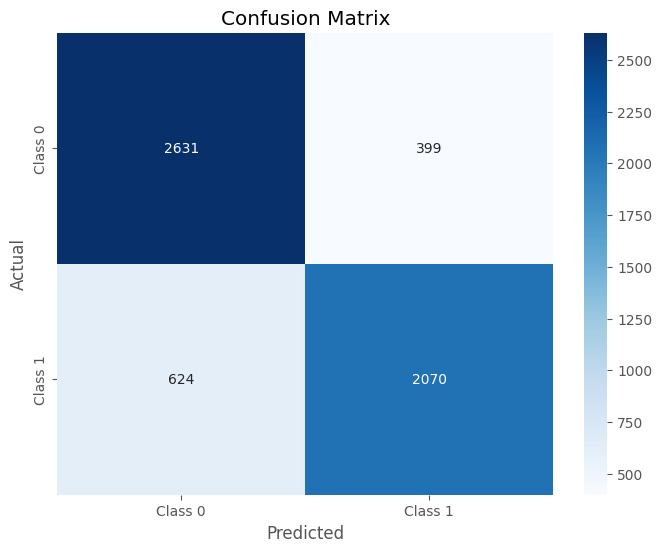

In [74]:
conf_matrix = confusion_matrix(y_test, pred_bnb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression

In [75]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [76]:
y_pred = logreg.predict(X_test)

In [77]:
print(f'Bernoulli Accuracy: {accuracy_score(y_test, y_pred)}')
print('\n')
print(classification_report(y_test, y_pred))

Bernoulli Accuracy: 0.8038085255066387


              precision    recall  f1-score   support

           0       0.80      0.83      0.82      3030
           1       0.81      0.77      0.79      2694

    accuracy                           0.80      5724
   macro avg       0.80      0.80      0.80      5724
weighted avg       0.80      0.80      0.80      5724



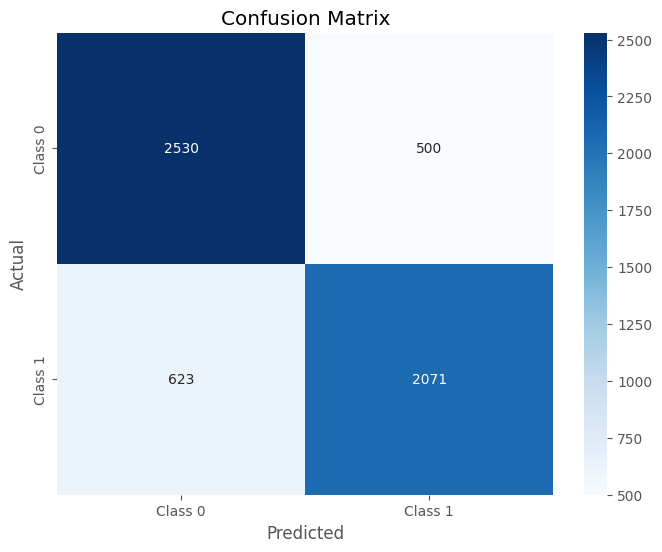

In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# LSTM _ Model 2

In [79]:
labels = (df['is_sarcastic'])
data = (df['headline'])

train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

X_train = data[:train_size]
y_train = labels[:train_size]

X_test = data[train_size:]
y_test = labels[train_size:]

In [80]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

27025


In [81]:
maxlen = max([len(i) for i in train_sequences])

In [82]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen,  padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen,  padding='post')

In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [84]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 107, 100)          2702600   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [85]:
history = model.fit(train_padded, np.array(y_train), validation_data=(test_padded,np.array(y_test)), epochs=5, verbose=2)

Epoch 1/5
716/716 - 199s - loss: 0.4788 - accuracy: 0.7572 - val_loss: 0.3982 - val_accuracy: 0.8110 - 199s/epoch - 278ms/step
Epoch 2/5
716/716 - 192s - loss: 0.2100 - accuracy: 0.9156 - val_loss: 0.4421 - val_accuracy: 0.8173 - 192s/epoch - 268ms/step
Epoch 3/5
716/716 - 193s - loss: 0.0898 - accuracy: 0.9678 - val_loss: 0.5818 - val_accuracy: 0.8084 - 193s/epoch - 270ms/step
Epoch 4/5
716/716 - 184s - loss: 0.0442 - accuracy: 0.9848 - val_loss: 0.8327 - val_accuracy: 0.7968 - 184s/epoch - 257ms/step
Epoch 5/5
716/716 - 192s - loss: 0.0234 - accuracy: 0.9917 - val_loss: 0.9342 - val_accuracy: 0.7951 - 192s/epoch - 268ms/step


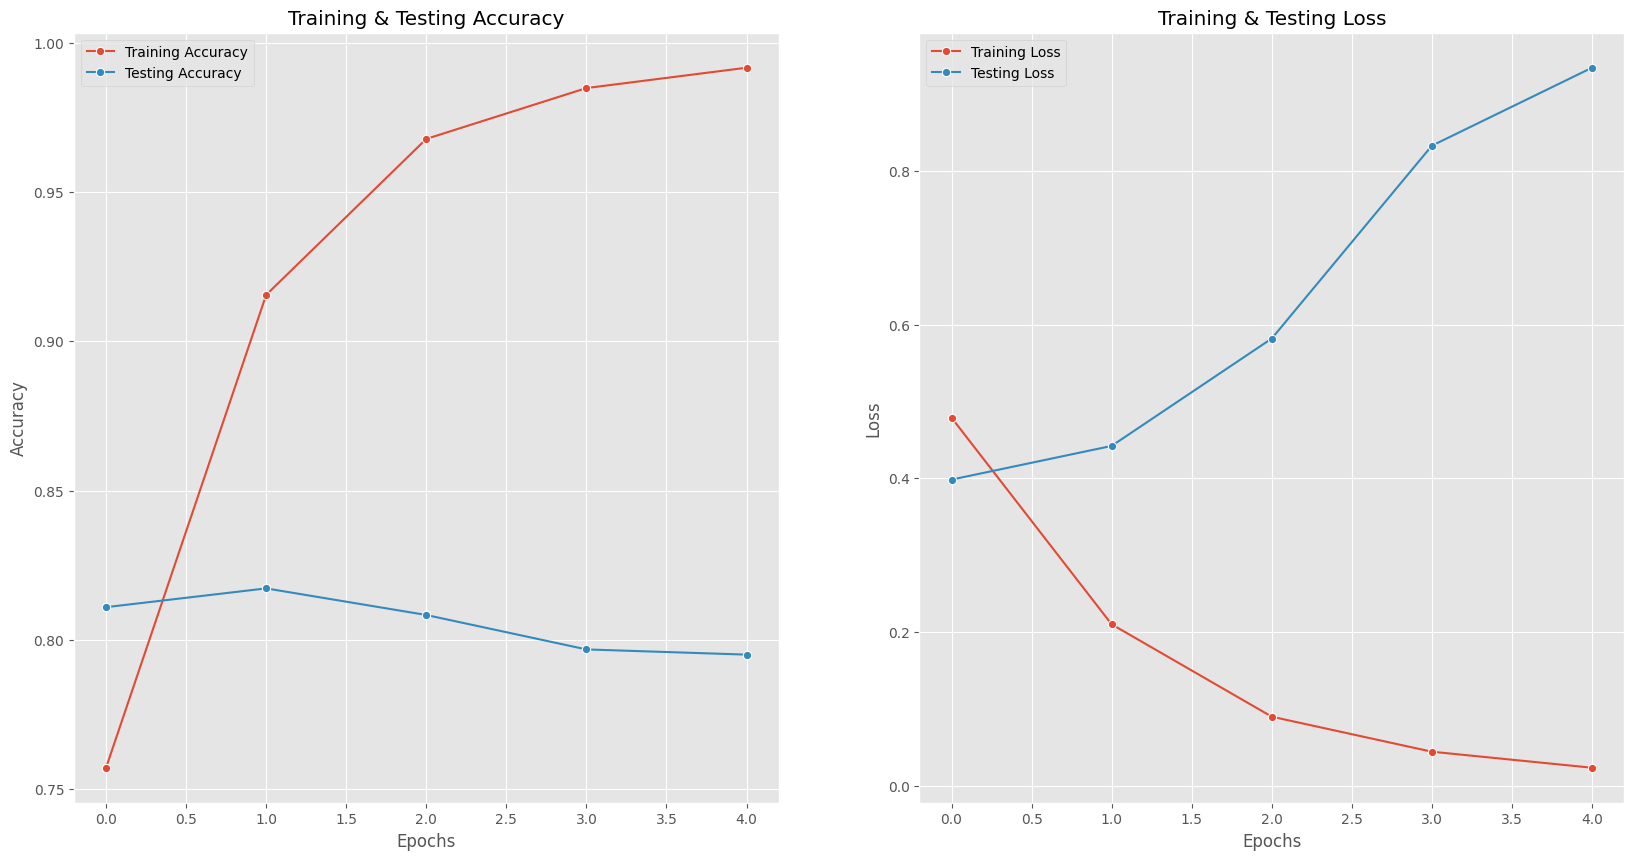

In [86]:
epochs = [i for i in range(5)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(x=epochs, y=train_acc, ax=axes[0], marker='o', label='Training Accuracy')
sns.lineplot(x=epochs, y=val_acc, ax=axes[0], marker='o', label='Testing Accuracy')
axes[0].set_title('Training & Testing Accuracy')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

sns.lineplot(x=epochs, y=train_loss, ax=axes[1], marker='o', label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, ax=axes[1], marker='o', label='Testing Loss')
axes[1].set_title('Training & Testing Loss')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

# LSTM - Model 3

In [87]:
labels = (df['is_sarcastic'])
data = (df['headline'])

train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

X_train = data[:train_size]
y_train = labels[:train_size]

X_test = data[train_size:]
y_test = labels[train_size:]

In [88]:
trunc = 'post'
padding = 'post'
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [90]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=32, padding=padding, truncating=trunc)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=32, padding=padding, truncating=trunc)

In [91]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=32),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [95]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            432400    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 432833 (1.65 MB)
Trainable params: 432833 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [97]:
num_epochs = 10

history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), verbose=2)

Epoch 1/10
716/716 - 6s - loss: 0.6235 - accuracy: 0.6421 - val_loss: 0.4834 - val_accuracy: 0.7769 - 6s/epoch - 8ms/step
Epoch 2/10
716/716 - 5s - loss: 0.3613 - accuracy: 0.8502 - val_loss: 0.4254 - val_accuracy: 0.8008 - 5s/epoch - 7ms/step
Epoch 3/10
716/716 - 5s - loss: 0.2411 - accuracy: 0.9077 - val_loss: 0.4341 - val_accuracy: 0.8104 - 5s/epoch - 7ms/step
Epoch 4/10
716/716 - 5s - loss: 0.1737 - accuracy: 0.9368 - val_loss: 0.4745 - val_accuracy: 0.8057 - 5s/epoch - 7ms/step
Epoch 5/10
716/716 - 5s - loss: 0.1281 - accuracy: 0.9549 - val_loss: 0.5444 - val_accuracy: 0.7966 - 5s/epoch - 7ms/step
Epoch 6/10
716/716 - 5s - loss: 0.0949 - accuracy: 0.9689 - val_loss: 0.6120 - val_accuracy: 0.7925 - 5s/epoch - 7ms/step
Epoch 7/10
716/716 - 5s - loss: 0.0721 - accuracy: 0.9783 - val_loss: 0.7127 - val_accuracy: 0.7781 - 5s/epoch - 7ms/step
Epoch 8/10
716/716 - 5s - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.7608 - val_accuracy: 0.7832 - 5s/epoch - 7ms/step
Epoch 9/10
716/716 - 5s 

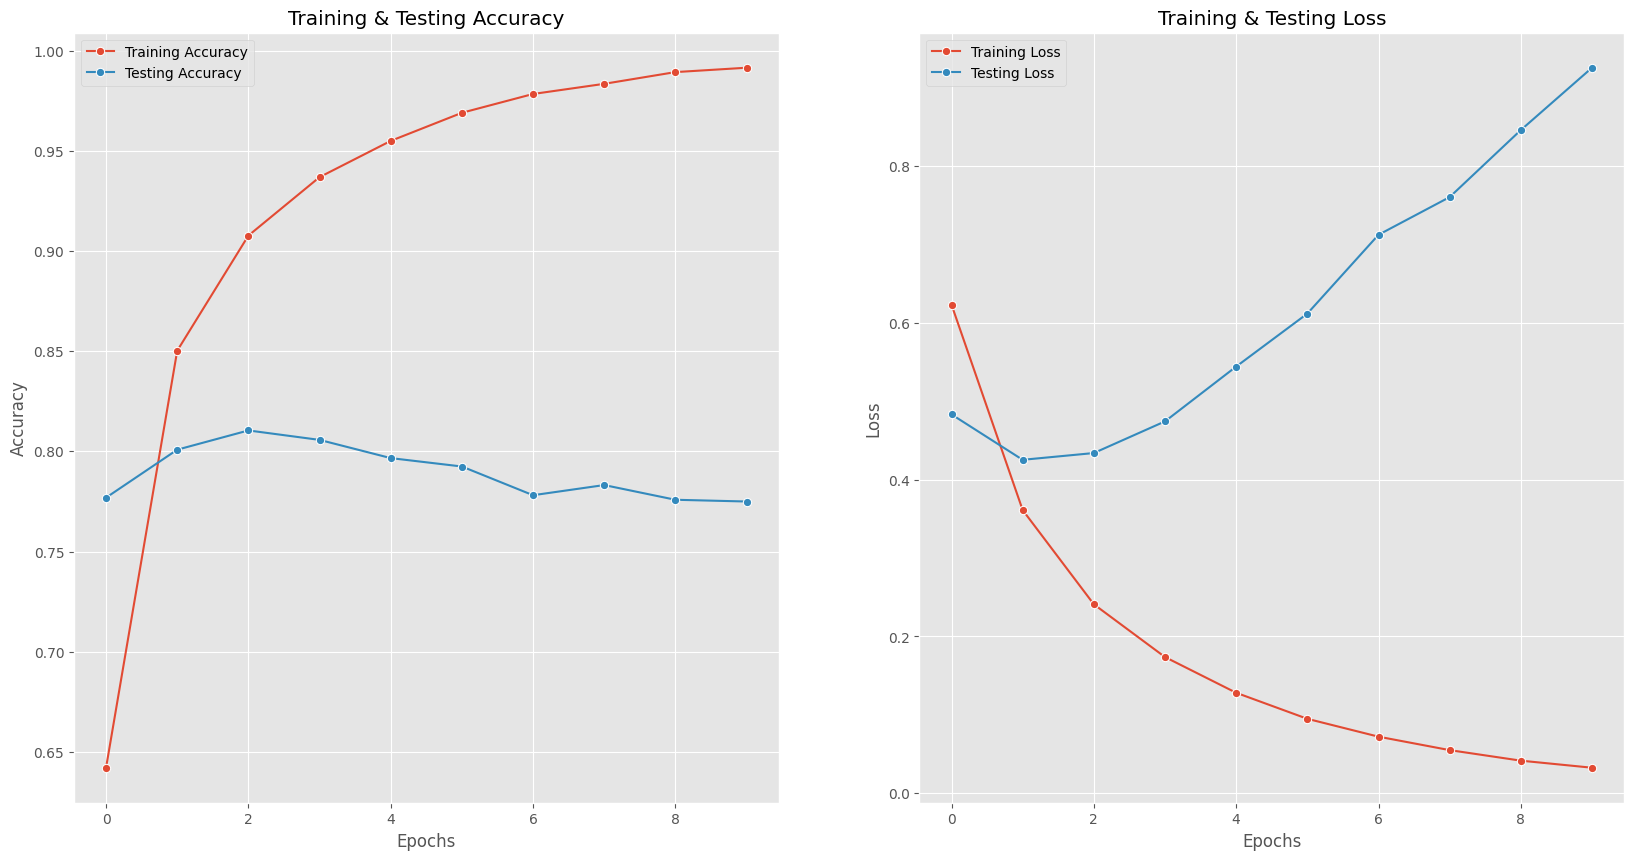

In [98]:
epochs = [i for i in range(10)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(x=epochs, y=train_acc, ax=axes[0], marker='o', label='Training Accuracy')
sns.lineplot(x=epochs, y=val_acc, ax=axes[0], marker='o', label='Testing Accuracy')
axes[0].set_title('Training & Testing Accuracy')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

sns.lineplot(x=epochs, y=train_loss, ax=axes[1], marker='o', label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, ax=axes[1], marker='o', label='Testing Loss')
axes[1].set_title('Training & Testing Loss')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()